## Evaluation of STT models

Load the benchmark dataset from huggingface

In [121]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("openpecha/tibetan-voice-benchmark")
df = pd.DataFrame(dataset['test'])

In [122]:
df.head()

,file_name,uni,wylie,url,dept
0,STT_MV0105_0153_1036457_to_1046241.wav,ཁོང་གིས་སྐུ་ངོ་རྨུང་ལགས་རྩ་ནས་གྱོད་གཞིའི་ཞུ་ཚི...,khong gis sku ngo rmung lags rtsa nas gyod gzh...,https://d38pmlk0v88drf.cloudfront.net/mv_wav/S...,STT_MV
1,STT_MV1789_0365_2511796_to_2519156.wav,གཟུགས་རྡུལ་དབང་ཤེས་སྐྱེད་མིན་ཏེ། དེ་ནི་དབང་པོ་...,gzugs rdul dbang shes skyed min te/_de ni dban...,https://d38pmlk0v88drf.cloudfront.net/mv_wav/S...,STT_MV
2,STT_TT00079_00406.600-00407.400,དོན་དུ་གཉེར་བའི་བློ་འདི།,don du gnyer ba'i blo 'di/_,https://d38pmlk0v88drf.cloudfront.net/wav/STT_...,STT_TT
3,STT_TT00188_00312.400-00314.000,ཁ་སང་སྔན་དུ་བ། ག་གེ་ཞིག་ཡོད་པ་མ་རེད།,kha sang sngan du ba/_ga ge zhig yod pa ma red/_,https://d38pmlk0v88drf.cloudfront.net/wav/STT_...,STT_TT
4,STT_TT00078_00581.450-00582.300,གཙུག་ལག་ཁང་དེ་བ་ལ་ཡ་,gtsug lag khang de ba la ya _,https://d38pmlk0v88drf.cloudfront.net/wav/STT_...,STT_TT


In [123]:
df.shape

(30973, 5)

In [124]:
i = 2431
df.loc[i, 'url'], df.loc[i, 'uni']

('https://d38pmlk0v88drf.cloudfront.net/wav/STT_AB00051_0099_899260_to_907849.wav',
 'གནས་བརྟན་རྣམས་ལ་ཕྱག་བགྱིད་དགོངས་སུ་གསོལ། མཆོད་སྦྱིན་ཐ་མ་འདི་ནི་བཞེས་སུ་གསོལ། ཞེས་ཞུས་ལ་ཕུལ་ཅིག་ཅེས་གསུངས་ནས་བཏང་ངོ་། ')

### An Example inference from different models

In [125]:
from transformers import pipeline
import pyewts
generator = pipeline(model="openpecha/wav2vec2_run8")
opt = generator(df.loc[i, 'url'])
inf = opt['text']
print("openpecha/wav2vec2_run8", inf)

generator = pipeline(model="TenzinGayche/whisper-small-3")
opt = generator(df.loc[i, 'url'])
inf = opt['text']
converter = pyewts.pyewts()
print("TenzinGayche/whisper-small-3", converter.toUnicode(inf))

generator = pipeline(model="spsither/whipser-small-r2")
opt = generator(df.loc[i, 'url'])
inf = opt['text']
converter = pyewts.pyewts()
print("spsither/whipser-small-r2", converter.toUnicode(inf))

openpecha/wav2vec2_run8 གནས་བརྟན་རྣམས་ལ་ཕྱག་གིས་གོངས་སུ་གསོལ། མཆོད་སྦྱིན་མཐའ་མ་འདི་ནི་ཞེས་སུ་གསོལ། ཞེས་ཞུས་ལ་ཕུལ་གཅིག་ཅེས་གསུང་ནས་བཏང་ངོ་།
TenzinGayche/whisper-small-3 གནས་བརྟན་རྣམས་ལ་ཕྱག་གིས་དགོངས་སུ་གསོལ༎མཆོད་སྦྱིན་ཐ་མ་དེ་ནི་ཞེས་སུ་སྲོལ༎ཞེས་ཞུས་ལ་ཁུལ་གཅིག་ཅེས་གསུངས་ནས་བཏང་ངོ་༎
spsither/whipser-small-r2 ༎གནས་བརྟན་རྣམས་ལ་ཕྱག་གིས་དགོངས་སུ་གསོལ༎མཆོད་སྦྱིན་ཐ་མ་དེ་ནི་ཞེས་སུ་བསོལ་ཞུས་ལབུལ་ཅིག་ཅེས་གསུངས་ནས་བཏང་ངོ་༎


### Inference on all the benchmark data with the latest model

In [ ]:
# import os
from transformers import pipeline
from datasets import Dataset
from tqdm.auto import tqdm

generator = pipeline(model="TenzinGayche/whisper-small-3", device="cuda:0")

def iterate_data(dataset):
    for i, item in enumerate(dataset):
        yield item["url"]

BATCH_SIZE = 16
predictions = []

# run streamed inference
for out in tqdm(generator(iterate_data(dataset['test']), batch_size=BATCH_SIZE), total=len(dataset['test'])//BATCH_SIZE):
    predictions.append(out["text"])

print(predictions[:5])

# df['inf']  = df.apply(lambda row: generator(row['url'])['text'], axis=1)
# updated_dataset = dataset.map(generate, batched=True, batch_size=8)

In [ ]:
df['inf'] = predictions

In [126]:
df.head()

,file_name,uni,wylie,url,dept
0,STT_MV0105_0153_1036457_to_1046241.wav,ཁོང་གིས་སྐུ་ངོ་རྨུང་ལགས་རྩ་ནས་གྱོད་གཞིའི་ཞུ་ཚི...,khong gis sku ngo rmung lags rtsa nas gyod gzh...,https://d38pmlk0v88drf.cloudfront.net/mv_wav/S...,STT_MV
1,STT_MV1789_0365_2511796_to_2519156.wav,གཟུགས་རྡུལ་དབང་ཤེས་སྐྱེད་མིན་ཏེ། དེ་ནི་དབང་པོ་...,gzugs rdul dbang shes skyed min te/_de ni dban...,https://d38pmlk0v88drf.cloudfront.net/mv_wav/S...,STT_MV
2,STT_TT00079_00406.600-00407.400,དོན་དུ་གཉེར་བའི་བློ་འདི།,don du gnyer ba'i blo 'di/_,https://d38pmlk0v88drf.cloudfront.net/wav/STT_...,STT_TT
3,STT_TT00188_00312.400-00314.000,ཁ་སང་སྔན་དུ་བ། ག་གེ་ཞིག་ཡོད་པ་མ་རེད།,kha sang sngan du ba/_ga ge zhig yod pa ma red/_,https://d38pmlk0v88drf.cloudfront.net/wav/STT_...,STT_TT
4,STT_TT00078_00581.450-00582.300,གཙུག་ལག་ཁང་དེ་བ་ལ་ཡ་,gtsug lag khang de ba la ya _,https://d38pmlk0v88drf.cloudfront.net/wav/STT_...,STT_TT


In [ ]:
df.to_csv('tibetan-voice-benchmark-with-inf.tsv', index=False, sep='\t')

In [145]:
df = pd.read_csv('tibetan-voice-benchmark-with-inf.csv')

In [128]:
import pyewts

converter = pyewts.pyewts()

df['inf_uni'] = df['inf'].map(lambda x : converter.toUnicode(x))

In [129]:
from evaluate import load

cer_metric = load("cer")

In [130]:
print([df.loc[0, 'uni']], [df.loc[0, 'inf_uni']])
cer = cer_metric.compute(references=[df.loc[0, 'uni']], predictions=[df.loc[0, 'inf_uni']])

print(cer)

['ཁོང་གིས་སྐུ་ངོ་རྨུང་ལགས་རྩ་ནས་གྱོད་གཞིའི་ཞུ་ཚིག་གཞན་དག་གཟིགས་ཀི་རེད་པེ། དེ་འདྲས་རྟག་པར་གནང་གི་རེད། ཁོང་གི་ཚ་བོས་ནག་ཉེས་བསགས་ཙང་། '] ['ཁོང་གིས་སྐུ་ངོ་རྨུང་ལགས་རྩ་ནས་གྱོད་གཞིའི་ཞུ་རྫས་གཅིག་བདག་ཟེར་གི་རེད་པེ་དེའདྲས་རྟག་པར་གནང་གི་རེ་རེད་ཁོང་གི་ཚ་བོས་ནག་ཉེས་བསགས་ཏང་མ་སོང་ན་ཁོས་ནང་ཉེ་བཟའ་']
0.3359375


In [131]:
def calculate_cer(row):
    try:
        uni = row['uni']
        inf_uni = row['inf_uni']
        cer = cer_metric.compute(references=[uni], predictions=[inf_uni])
        cer = min(cer, 1.0)
        return cer
    except:
        return 0.0

In [132]:
df['cer'] = df.apply(lambda row: calculate_cer(row), axis=1)

### The Average CER

In [133]:
df['cer'].mean()

0.37937862316524784

### Department wise CER

In [154]:
df[['file_name', 'dept']].groupby('dept').count()

,file_name
dept,
STT_AB,2794
STT_CS,1945
STT_MV,8370
STT_NS,2522
STT_TT,15342


In [75]:
df.groupby('dept').mean('cer')

,cer
dept,
STT_AB,0.159667
STT_CS,0.479060
STT_MV,0.760679
STT_NS,0.340796
STT_TT,0.205074


### If we take out MV

In [77]:
df[df['dept'] != 'STT_MV']['cer'].mean()

0.238181370071628

### Breakdown of CS

https://github.com/MonlamAI/STT-template/blob/main/README.md

In [79]:
df = df[df['dept'] == 'STT_CS']

In [134]:
def parse_cs_file_name(code):
    
    try:
        # Split the code into parts
        parts = code.split('-')

        # Decode each part of the code
        
        data_type = {'X': 'non-designated', 'D': 'story-telling', 'L':'conversation'}.get(parts[1], 'Unknown')
        birth_year = parts[2][:4]
        gender = {'P': 'male', 'M': 'female', 'X': 'other'}.get(parts[3][:1], 'Unknown')
        location = {'D': 'Dharamsala', 'S': 'South India', 'L': 'Ladakh', 'N': 'Nepal'}.get(parts[4][:1], 'Unknown')
        education_type = parts[5][0]
        education_years = parts[5][1:3]
        grade_level = parts[6][:1]
        school_code = parts[7][:1]

        # Create a dictionary with the decoded values
        decoded = {
            'data_type': data_type,
            'birth_year': int(birth_year),
            'age': 2023 - int(birth_year),
            'gender': gender,
            'location': location,
            'education_type': education_type,
            'education_years': int(education_years),
            'grade_level': int(grade_level),
            'school_code': school_code
        }
    except:
        # print(f'Error decoding {code}')
        return {}
    return decoded

# Example usage
codes = [
    'STT_CS-D-2016-M-D-B04-1-R-06_0017_147090_to_156979',
    'STT_CS-X-2014-M-D-B02-4-R-01_0110_1035711_to_1037787',
    'STT_CS-L-2014/2014-P/P-D/D-B03/B06-5/5-R/R-01_0129_1106637_to_1112914.mp3',
]

for code in codes:
    print(parse_cs_file_name(code))


{'data_type': 'story-telling', 'birth_year': 2016, 'age': 7, 'gender': 'female', 'location': 'Dharamsala', 'education_type': 'B', 'education_years': 4, 'grade_level': 1, 'school_code': 'R'}
{'data_type': 'non-designated', 'birth_year': 2014, 'age': 9, 'gender': 'female', 'location': 'Dharamsala', 'education_type': 'B', 'education_years': 2, 'grade_level': 4, 'school_code': 'R'}
{'data_type': 'conversation', 'birth_year': 2014, 'age': 9, 'gender': 'male', 'location': 'Dharamsala', 'education_type': 'B', 'education_years': 3, 'grade_level': 5, 'school_code': 'R'}


In [135]:
df_parsed = df['file_name'].apply(lambda x: pd.Series(parse_cs_file_name(x)))
df = pd.concat([df, df_parsed], axis=1)

In [136]:
df.columns

Index(['file_name', 'uni', 'wylie', 'url', 'dept', 'inf', 'inf_uni', 'cer',
       'data_type', 'birth_year', 'age', 'gender', 'location',
       'education_type', 'education_years', 'grade_level', 'school_code'],
      dtype='object')

### Age

In [137]:
df[['age', 'cer']].groupby('age').mean('cer')

,cer
age,
4.0,0.532205
5.0,0.533215
6.0,0.565959
7.0,0.485130
8.0,0.488292
9.0,0.434668
10.0,0.462836
11.0,0.459864
12.0,0.457008


### This looks like a pattern if we ignore the 14 age group

<Axes: xlabel='age'>

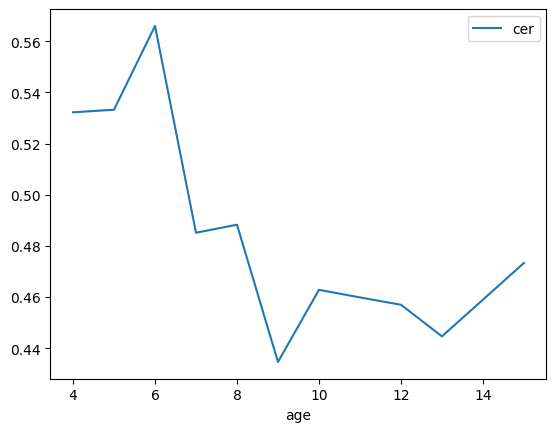

In [138]:
df[df['age'] != 14][['age', 'cer']].groupby('age').mean('cer').plot()

### Gender

In [139]:
df[['gender', 'cer']].groupby('gender').mean('cer')

,cer
gender,
female,0.477607
male,0.479985


### Grade Level

<Axes: xlabel='grade_level'>

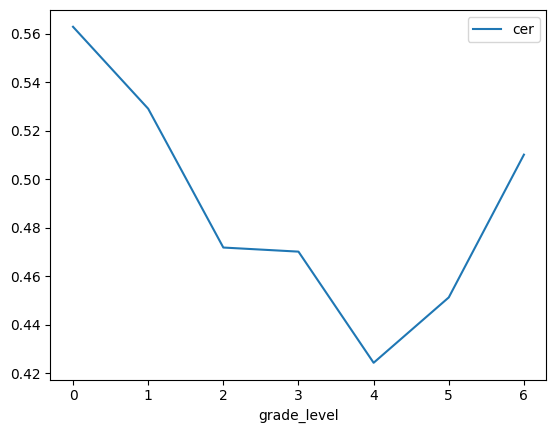

In [140]:
df[['grade_level', 'cer']].groupby('grade_level').mean('cer').plot()

### School Code
School Code is which school the subject's data was collected from
* R = རྡ་སྟེང་བོད་ཁྱིམ་སློབ་གྲྭ
* B = བོད་ཁྱིམ་ཉིན་མོའི་སློབ་གྲྭ
* D = དྷ་ཤོད་བོད་ཁྱིམ་སློབ་གྲྭ
* Y = ཡོངས་གླིང་སློབ་གྲྭ
* P = སྤོན་ཊ་སློབ་གྲྭ
* S = ཤེས་རབ་དགའ་ཚལ་སློབ་གླིང་།
* M = མན་ཇུ་ཤི་རི།
* G = གོ་པལ་པུར་སློབ་གྲྭ
* T = སམ་བྷོ་ཊ་སློབ་གྲྭ
* Z = སུ་ཇཱ་སློབ་གྲྭ
* C = ཅོན་ཏ་ར་བོད་ཁྱིམ་སློབ་གྲྭ
* K = རྒྱུད་སྟོད་གྲྭ་ཚང་།
* N = རྣམ་རྒྱལ་གྲྭ་ཚང་།
* A = ཤུག་གསེབ་ཨ་ནེའི་དགོན་པ།
* L = དགེ་ལྡན་ཆོས་གླིང་།
* X = མེད་པ།

<Axes: xlabel='school_code'>

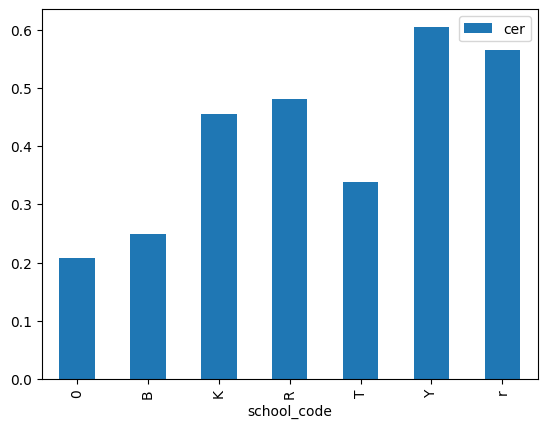

In [120]:
df[['school_code', 'cer']].groupby('school_code').mean('cer').plot.bar()

### Education Years

<Axes: xlabel='education_years'>

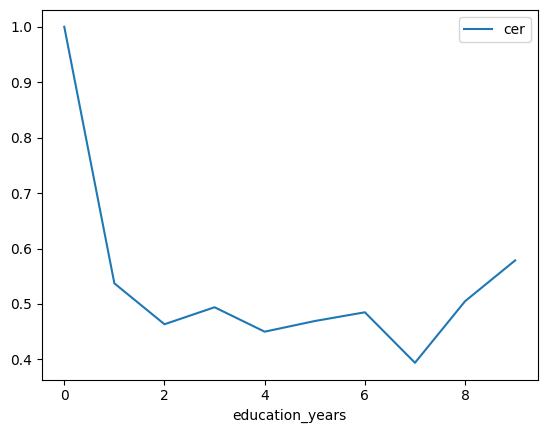

In [119]:
df[['education_years', 'cer']].groupby('education_years').mean('cer').plot()

### Education Type
* G = monastic
* B = Tibetan school 
* R = Indian school (or other public / private school) 
* X = None

<Axes: xlabel='education_type'>

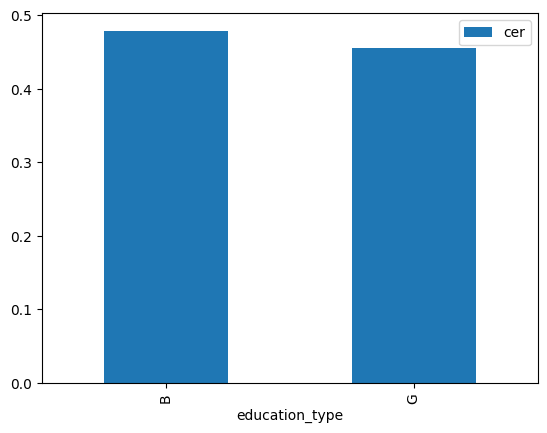

In [144]:
df[['education_type', 'cer']].groupby('education_type').mean('cer').plot.bar()